# EXTRACTOR Nº 3: BAG OF WORDS

In [1]:
import numpy as np
import os
import pandas as pd
import cv2
import faiss
import glob
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import cv2 
import time
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.cluster.vq import kmeans, vq

Preparamos las imágenes:

In [2]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Cargar la imagen
    img = Image.open(image_path).convert('RGB')
    # Redimensionar la imagen al tamaño objetivo
    img = img.resize(target_size)
    # Convertir la imagen en un array de numpy y normalizar (escalar píxeles a 0-1)
    img_array = np.array(img)
    return img_array

# Ruta principal donde está almacenado el dataset
dataset_path = Path("./DatasetArteTrainTest/Train")

# Creamos el DataFrame vacío
df = pd.DataFrame()

# Obtenemos todas las imágenes en cada subcarpeta
df['image'] = [str(file) for file in dataset_path.rglob('*.jpg') if file.is_file()]
df['Preprocessed_Images'] = df['image'].apply(preprocess_image)

# Verificamos las primeras filas para asegurarnos de que las rutas están correctas y que están todas las imagenes. 
img_train = np.array(df['Preprocessed_Images'].tolist())

Para empezar, y para poder visualizar mejor el proceso que vamos a seguir. Comenzamos comparando los extractores SIFT y ORB para elegir cuál vamos a utilizar. 

ORB time:  0.36713576316833496  SIFT time:  0.020180940628051758


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

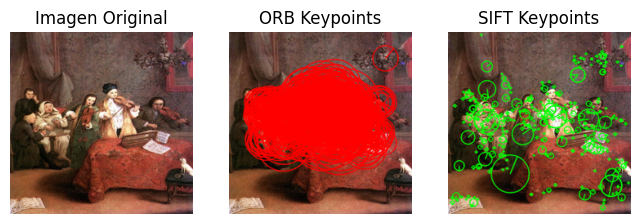

In [3]:
# Crear detectores ORB y SIFT
orb = cv2.ORB_create()  # ORB con 10 características máximas
sift = cv2.SIFT_create()           # SIFT

# Detectar y computar keypoints y descriptores con ORB
start_time = time.time()
kp_orb, des_orb = orb.detectAndCompute(img_train[0], None)
end_time = time.time()
time_orb = end_time - start_time

# Detectar y computar keypoints y descriptores con SIFT
start_time = time.time()
kp_sift, des_sift = sift.detectAndCompute(img_train[0], None)
end_time = time.time()
time_sift = end_time - start_time

# Dibujar los puntos clave detectados en la primera imagen de entrenamiento
img_orb = cv2.drawKeypoints(
    img_train[0], kp_orb, None, (255, 0, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

img_sift = cv2.drawKeypoints(
    img_train[0], kp_sift, None, (0, 255, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

print('ORB time: ', time_orb, ' SIFT time: ', time_sift)

# Mostrar ambas imágenes lado a lado para comparación
fig, axs = plt.subplots(1, 3, figsize=(8, 4))

# Imagen original
axs[0].imshow(img_train[0], cmap='gray')
axs[0].set_title('Imagen Original')
axs[0].axis('off')

# ORB
axs[1].imshow(img_orb, cmap='gray')
axs[1].set_title('ORB Keypoints')
axs[1].axis('off')

# SIFT
axs[2].imshow(img_sift, cmap='gray')
axs[2].set_title('SIFT Keypoints')
axs[2].axis('off')

Como podemos observar ORB tiene un exceso de puntos clave concentrados en zonas sin importancia visual, como la mesa, mientras que en SIFT los puntos parecen mejor distribuidos. Sin embargo, SIFT tarda el doble de tiempo, de forma que, para optimizar el tiempo de cómputo utilizaremos ORB. 

Pasamos entonces a calcular los patches de cada imagen que nos servirán para definir las palabras visuales de nuestro vocabulario. 

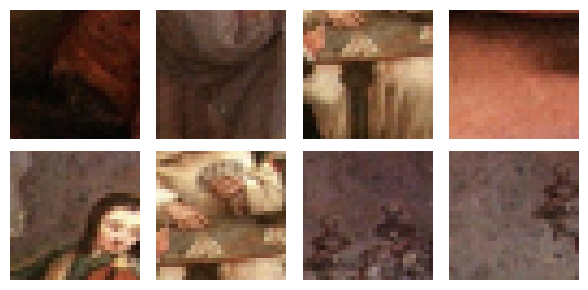

In [4]:
# Función para extraer parches de una imagen
def extract_image_patches(image, random_state, patch_size, n_patches=250):
    patches = extract_patches_2d(
        image, 
        patch_size=patch_size, 
        max_patches=n_patches, 
        random_state=random_state
    )
    return patches.reshape((n_patches, -1))

# Extraer parches para todas las imágenes
def extract_patches_from_dataset(dataset, patch_size=(30, 30), n_patches=250, random_seed=0):
    random_state = np.random.RandomState(random_seed)
    return [
        extract_image_patches(img, random_state, patch_size, n_patches) 
        for img in dataset
    ]

# Función para visualizar parches
def visualize_patches(patches, patch_shape=(30, 30, 3), num_patches=10):
    plt.figure(figsize=(6, 3))
    for i in range(num_patches):
        plt.subplot(2, (num_patches // 2), i + 1)
        plt.imshow(patches[i].reshape(patch_shape))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Extraer parches de img_train
patches = extract_patches_from_dataset(img_train)

# Visualizar los primeros 10 parches de la primera imagen
visualize_patches(patches[0], patch_shape=(30, 30, 3), num_patches=8)

Ahora vamos  aproceder a calcular los descriptores para cada patch:

In [5]:
orb = cv2.ORB_create()
keypoints = []
descriptors = []

for patch in patches:
    patch_keypoints, patch_descriptors = orb.detectAndCompute(patch, None)
    keypoints.append(patch_keypoints)
    descriptors.append(patch_descriptors)

Ponemos todos los descriptores en un solo array:

In [6]:
# Convertir todos los descriptores de las imágenes en un solo array
all_descriptors = np.vstack([np.array(img_descriptors, dtype=np.float32) for img_descriptors in descriptors])

Ahora procedemos a aplicar kmeans para obtener la agrupación en clusters, donde cada cluster representará una palabra de nuestro diccionario. 

In [7]:
filename = 'Bag_Of_Words.npy'
k = 250
if not os.path.exists(filename):
    # Runtime: 11min
    codebook, _ = kmeans(all_descriptors, k)
    np.save(filename, codebook)
else:
    codebook = np.load(filename)

visual_words = []
for img_descriptors in descriptors:
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

Ahora, por cada imagen tendremos que obtener los vectores de frecuencia, es decir, cuántas veces aparece cada palabra del diccionario que hemos creado en dicha imagen. 

In [8]:
frequency_values = np.array([np.bincount(img_visual_words, minlength=k) for img_visual_words in visual_words])

Estos serán las características que utilizaremos para comparar las imágenes:

In [9]:
def preprocess_features(train_feats):
    train_feats = np.array(frequency_values, dtype=np.float32)
    faiss.normalize_L2(train_feats)
    return train_feats

filename = 'database/feat_extract_3.index'
# filename = 'feat_extract_BpW'
if not os.path.exists(filename):
    train_feats = preprocess_features(frequency_values)
    index = faiss.IndexFlatL2(train_feats.shape[1])
    index.add(train_feats)
    faiss.write_index(index, filename)
else:
    index = faiss.read_index(filename)

In [10]:
def extract_image_patches(image, random_state, patch_size=(30, 30), n_patches=250):
    patches = extract_patches_2d(
        image, 
        patch_size=patch_size, 
        max_patches=n_patches, 
        random_state=random_state
    )
    return patches.reshape((n_patches, -1))

def bag_of_words_extractor(img_query):
    codebook = np.load('Bag_Of_Words.npy')
    orb = cv2.ORB_create()
    image = np.asarray(img_query)
    patch_size=(30, 30)
    n_patches=250
    random_seed=0
    random_state = np.random.RandomState(random_seed)
    patches = []
    patches.append(extract_image_patches(image, random_state, patch_size, n_patches))

    keypoints = []
    descriptors = []
    for patch in patches:
        patch_keypoints, patch_descriptors = orb.detectAndCompute(patch, None)
        keypoints.append(patch_keypoints)
        descriptors.append(patch_descriptors)

    visual_words = [vq(desc, codebook)[0] for desc in descriptors]
    frequency_values = [np.bincount(word, minlength=250) for word in visual_words]

    return frequency_values


In [11]:
test_dir = "./DatasetArteTrainTest/Test/"
query_index = 7
query_image = os.path.join(test_dir, os.listdir(test_dir)[query_index])
query_image = preprocess_image(query_image)
k = 11

feature_vector_bow = bag_of_words_extractor(query_image)
feature_vector = np.float32(feature_vector_bow)
faiss.normalize_L2(feature_vector)
_, indices = index.search(feature_vector, k)
nearest_images = [img_train[idx] for idx in indices[0]]

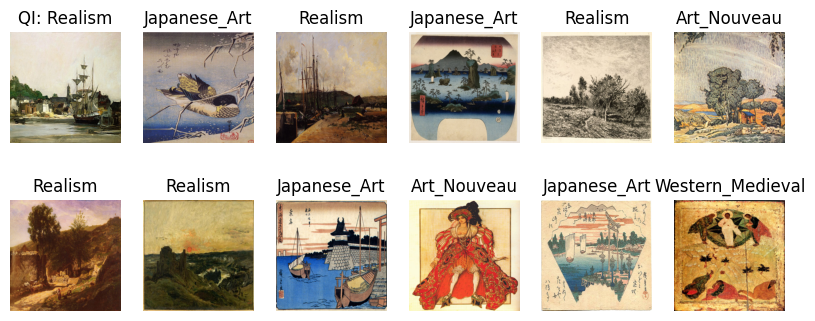

In [12]:
def show_result(similar_images, query_image):
    k = len(similar_images)

    # Crear una figura y subgráficas (subplots)
    fig, axes = plt.subplots(2, int((k + 1)/2), figsize=(10, 4))

    axes = axes.flatten()

    # Plotear la imagen de consulta
    axes[0].imshow(query_image)
    axes[0].set_title("QI: " + os.listdir(test_dir)[query_index].split('-')[1].split('.')[0])
    axes[0].axis('off')

    # Plotear las imágenes más similares
    for i, sim_img in enumerate(similar_images):
        axes[i + 1].imshow(sim_img)
        img_name = Path(df['image'][indices[0][i]]).name.split('-')[1].split('.')[0]  
        axes[i + 1].set_title(img_name)
        axes[i + 1].axis('off')

    plt.show()

show_result(nearest_images, query_image)